In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment4

/home/pengyu.zhang/project/superres/ProbSR/Experiment4


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
import cv2
import torchvision.transforms as T
import torch.nn.functional as F
import time
import random

## Bicubic interpolation downscale

### Upscale by 4

In [34]:
N_low = 97
N_high = 97*4+1
scale = 4
a, b, c, d = 2.5,2.5,1,1

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [35]:
w_low, r_low, A_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high = generate_data(N_high,a,b,c,d)
dimension_low = w_low.shape[0]
dimension_high = w_high.shape[0]

/home/pengyu.zhang/project/superres/ProbSR/Experiment4/data_generation.py:301: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = linalg.spsolve(A,r)


In [37]:
start = time.time()
u = linalg.spsolve(A_high,r_high)
end = time.time()
print(end-start)

/tmp/ipykernel_2217770/260925107.py:2: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = linalg.spsolve(A_high,r_high)


0.4981863498687744


In [38]:
def to_torch_tensor(A):
    coo = A.tocoo()
    values = coo.data
    indices = np.vstack((coo.row,coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    sparse_tensor = torch.sparse.FloatTensor(i,v,torch.Size(shape))

    return sparse_tensor

# A_high = to_torch_tensor(A_high)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0006
ll_sigma = 0.0006

In [54]:
operator = (A_high.T) * (1/prior_sigma**2)
# b_high = torch.tensor(create_forcing_term(N_high,a,b,c,d)).to(torch.float32)
b_high = create_forcing_term(N_high,a,b,c,d)
H = create_H(N_low,N_high)
H = to_torch_tensor(H)

In [41]:
# Parameters for Langevin dynamics
K = 30
s = 0.0001

x = torch.tensor(w_low).to(torch.float32).reshape(dimension_low,1)
chains_evolution = []

startTime = time.time()

posterior_initial = partial_bicubic(N_low,N_high,w_low)
z = torch.tensor(posterior_initial).to(torch.float32)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    x_hat = torch.spmm(H,z)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,dimension_low),(x-x_hat).reshape(dimension_low,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # Grad prior
    difference = A_high.dot(z.reshape(dimension_high,1).cpu().data.numpy()) - b_high.reshape(dimension_high,1)
    grad_log_prior = torch.tensor(-operator.dot(difference)).to(torch.float32)
    
    # Random noise term
    W = torch.randn((dimension_high,1))
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())

endTime = time.time()
print(endTime-startTime) 

0.6177093982696533


In [57]:
# Parameters for Langevin dynamics
K = 30
s = 0.0001

x = torch.tensor(w_low).to(torch.float32).reshape(dimension_low,1)
chains_evolution = []

startTime = time.time()

posterior_initial = partial_bicubic(N_low,N_high,w_low)
z = torch.tensor(posterior_initial).to(torch.float32)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    grad_ll = (-1/(math.pow(ll_sigma, 2)) * torch.spmm(H.T,(x-torch.spmm(H,z))))

    # Grad prior
    difference = A_high.dot(z.reshape(dimension_high,1).cpu().data.numpy()) - b_high.reshape(dimension_high,1)
    grad_log_prior = torch.tensor(-operator.dot(difference)).to(torch.float32)
    
    # Random noise term
    W = torch.randn((dimension_high,1))
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())

endTime = time.time()
print(endTime-startTime) 

0.6476104259490967


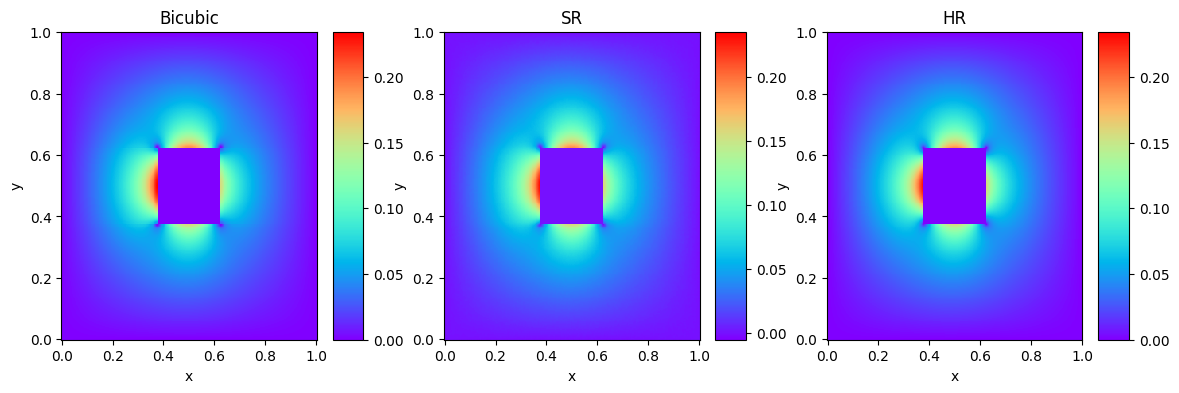

In [33]:
u_sr_whole = transfer_to_u_whole(N_high,z.cpu().data.numpy())
u_bicubic_sr = transfer_to_u_whole(N_high, posterior_initial)
u_high_whole = transfer_to_u_whole(N_high,w_high)

fig = plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, u_bicubic_sr, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
plt.pcolormesh(x_high, y_high, u_sr_whole, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, u_high_whole, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
error1 = w_high - z.cpu().data.numpy()
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

: 

In [61]:
error1 = abs(w_high - posterior_initial)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.001971047978155452


In [54]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0019596017529769855
